In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
import umap
import datashader as ds
import colorcet as cc
import igraph
import tqdm
from scipy import sparse
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from scipy.spatial import Delaunay

from matplotlib.collections import PolyCollection
from matplotlib.colors import ListedColormap

from dredFISH.Analysis import TissueGraph
from dredFISH.Visualization import Viz
from dredFISH.Utils.__init__plots import * 
from dredFISH.Utils import powerplots
from dredFISH.Utils import miscu
from dredFISH.Utils import tmgu

import importlib
importlib.reload(Viz)
importlib.reload(TissueGraph)

<module 'dredFISH.Analysis.TissueGraph' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Analysis/TissueGraph.py'>

#### Load data

In [2]:
respath = '/bigstore/GeneralStorage/fangming/projects/dredfish/figures/'

In [3]:
basepth = '/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5'
!ls -alhtr $basepth
!head $basepth"/TMG.json"

total 85M
drwxrwxrwx 9 zach     wollmanlab 4.0K Jul 20 10:38 ..
lrwxrwxrwx 1 fangming wollmanlab   67 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_matrix.csv
lrwxrwxrwx 1 fangming wollmanlab   69 Jul 20 10:38 DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv -> ../Dataset1-t4/DPNMF_PolyA_2021Nov19_Section_-1850X_270Y_metadata.csv
-rw-r--r-- 1 fangming wollmanlab   32 Jul 20 10:39 README.txt
-rw-r--r-- 1 fangming wollmanlab   88 Jul 20 10:41 TMG.json
-rw-r--r-- 1 fangming wollmanlab  53M Jul 20 10:41 cell.h5ad
drwxr-xr-x 3 fangming wollmanlab 4.0K Jul 20 10:45 .
-rw-r--r-- 1 fangming wollmanlab  32M Jul 20 10:45 default_analysis.csv
drwxr-xr-x 4 fangming wollmanlab 4.0K Jul 21 11:49 figures
{"layers_graph": [], "layer_taxonomy_mapping": {}, "Taxonomies": [], "Layers": ["cell"]}

In [4]:
df = pd.read_csv(
    os.path.join(basepth, "default_analysis.csv"), index_col=0)
df

x            y           x2           y2  hemi        b0  \
0      1911.666962 -1749.638192  1833.366541 -1831.521636     1 -0.603849   
1      1850.678429 -1747.172043  1772.544083 -1826.392145     1 -0.530279   
2      1515.123295 -1746.940031  1437.319766 -1811.493848     1 -0.603849   
3      1426.161788 -1748.456394  1348.376999 -1809.120415     1 -0.298989   
4      1739.792930 -1749.407386  1661.666850 -1823.778747     1 -0.603849   
...            ...          ...          ...          ...   ...       ...   
77841 -2188.756848 -1084.480934 -2234.065840  -987.777939     0 -0.603849   
77842 -2257.822983 -1083.270665 -2303.013073  -983.550072     0  0.936062   
77843 -2475.320577 -1083.995803 -2520.334508  -974.768090     0 -0.603849   
77844 -2311.578984 -1086.717336 -2356.868349  -984.643871     0 -0.603849   
77845 -2403.465132 -1086.924513 -2448.675740  -980.834673     0 -0.603849   

             b1        b2        b3        b4  ...  type_r0.01  type_r0.02  \
0      1.714861  0.594060  0.139496  1.509942  ...          t1          t1   
1      1.681959  1.301185 -0.464006  1.570054  ...          t1          t1   
2     -0.362498  0.620053 -1.128423  1.206578  ...          t1          t1   
3      1.023065  1.517082 -0.341796  0.475449  ...          t1          t1   
4     -1.351786  1.025515 -1.128423  0.327118  ...          t1          t1   
...         ...       ...       ...       ...  ...         ...         ...   
77841 -0.271399 -0.666686  0.269214  0.821624  ...          t1          t1   
77842  0.386319 -0.614982  1.752306  0.067531  ...          t1          t1   
77843 -0.228163 -0.612215  0.895132  0.247026  ...          t1          t1   
77844 -1.153599  0.699586 -0.204732  1.546018  ...          t1          t1   
77845  0.607199 -0.115740  0.270087  1.087780  ...          t1          t1   

       type_r0.05  type_r0.1  type_r0.2  type_r0.5  type_r1  type_r2  type_r5  \
0              t1         t3         t2         t4       t3      t16      t47   
1              t1         t3         t2         t4       t3      t16      t47   
2              t1         t3         t2        t10       t9      t20      t24   
3              t1         t3         t2        t10       t9      t20      t51   
4              t1         t1         t1         t1       t2       t3      t34   
...           ...        ...        ...        ...      ...      ...      ...   
77841          t1         t3         t2         t8      t18      t36      t56   
77842          t3         t4         t6         t8      t10       t6       t1   
77843          t2         t2         t5         t6       t7      t25      t41   
77844          t1         t1         t1         t1       t1       t5      t12   
77845          t3         t4         t6         t8      t10       t6       t1   

       type_r10  
0           t40  
1           t40  
2           t66  
3          t121  
4           t21  
...         ...  
77841       t57  
77842       t73  
77843       t82  
77844       t26  
77845       t23  

[77846 rows x 44 columns]

In [5]:
TMG = TissueGraph.TissueMultiGraph(basepath=basepth, 
                                   redo=False, # load existing 
                                  )

/bigstore/GeneralStorage/Data/dredFISH/Dataset1-t5/cell.h5ad


In [6]:
# spatial coordinates
layer = TMG.Layers[0]
XY = layer.XY
x, y = XY[:,0], XY[:,1]
###
x, y = y, x # a temporary hack
###

cells = layer.adata.obs.index.values

N = layer.N
# measured basis
ftrs_mat = layer.feature_mat

# umap_mat = umap.UMAP(n_neighbors=30, min_dist=0.1).fit_transform(ftrs_mat)



In [7]:
# types
types = df['type_r0.1'].values
# local env
# env_mat = get_local_typeabundance(layer.SG, types)

In [8]:
dd = Delaunay(XY)
EL = np.zeros((dd.simplices.shape[0]*3,2),dtype=np.int64)
for i in range(dd.simplices.shape[0]): 
    EL[i*3,  :] = [dd.simplices[i,0], dd.simplices[i,1]]
    EL[i*3+1,:] = [dd.simplices[i,0], dd.simplices[i,2]]
    EL[i*3+2,:] = [dd.simplices[i,1], dd.simplices[i,2]]
    
tSG = igraph.Graph(n=len(XY), edges=list(zip(EL[:,0], EL[:,1])), directed=False).simplify()

In [9]:
tSG_adj = tSG.get_adjacency_sparse()
tSG_recon = tmgu.adjacency_to_igraph(tSG_adj, directed=False)

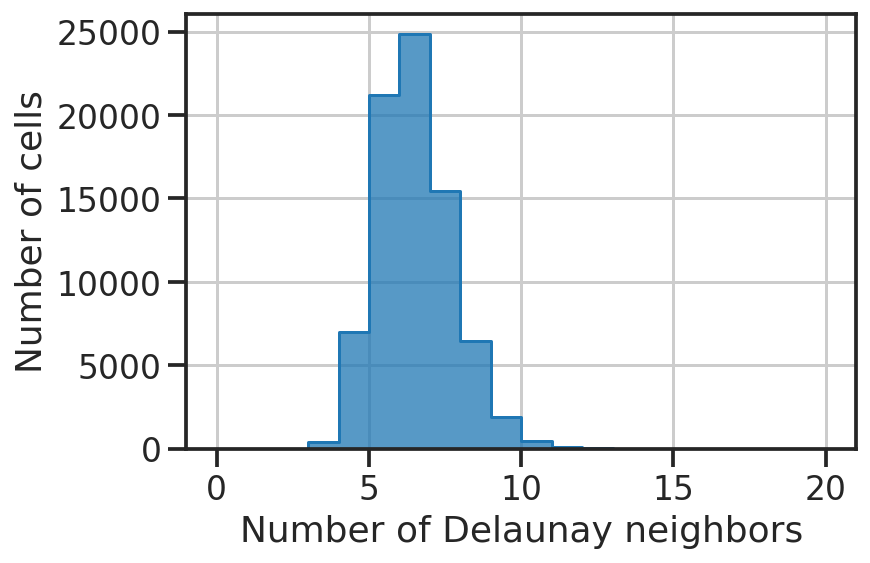

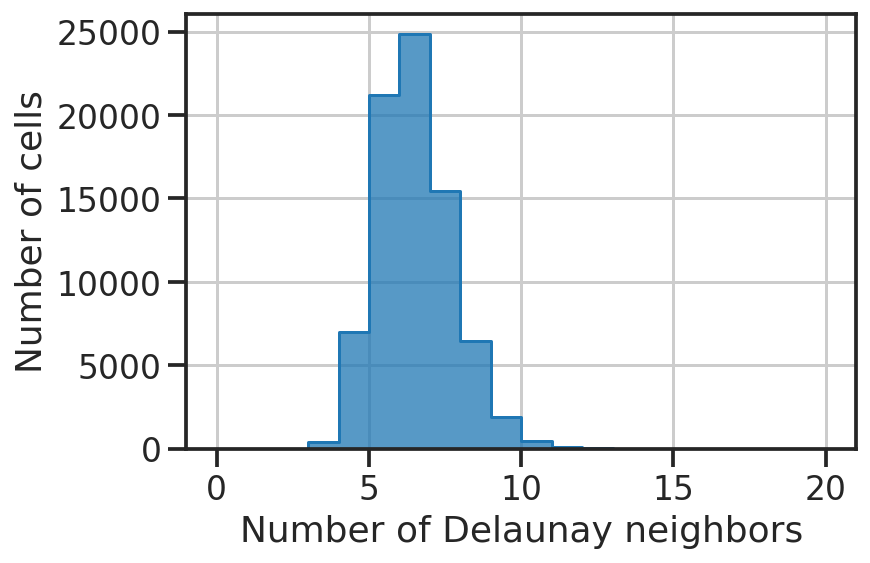

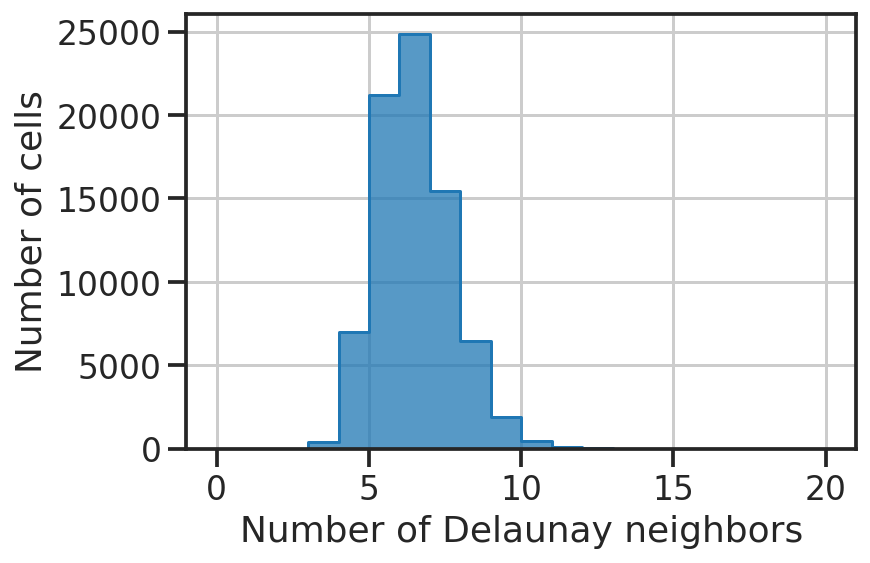

In [14]:
dgr = layer.SG.indegree() # same as out
dgr_t = tSG.indegree()
dgr_tr = tSG_recon.indegree()

fig, ax = plt.subplots()
sns.histplot(data=dgr, element='step', bins=np.arange(0, 21), ax=ax)
ax.set_xlabel('Number of Delaunay neighbors')
ax.set_ylabel('Number of cells')
plt.show()

fig, ax = plt.subplots()
sns.histplot(data=np.array(dgr_t), element='step', bins=np.arange(0, 21), ax=ax)
ax.set_xlabel('Number of Delaunay neighbors')
ax.set_ylabel('Number of cells')
plt.show()

fig, ax = plt.subplots()
sns.histplot(data=dgr_tr, element='step', bins=np.arange(0, 21), ax=ax)
ax.set_xlabel('Number of Delaunay neighbors')
ax.set_ylabel('Number of cells')
plt.show()

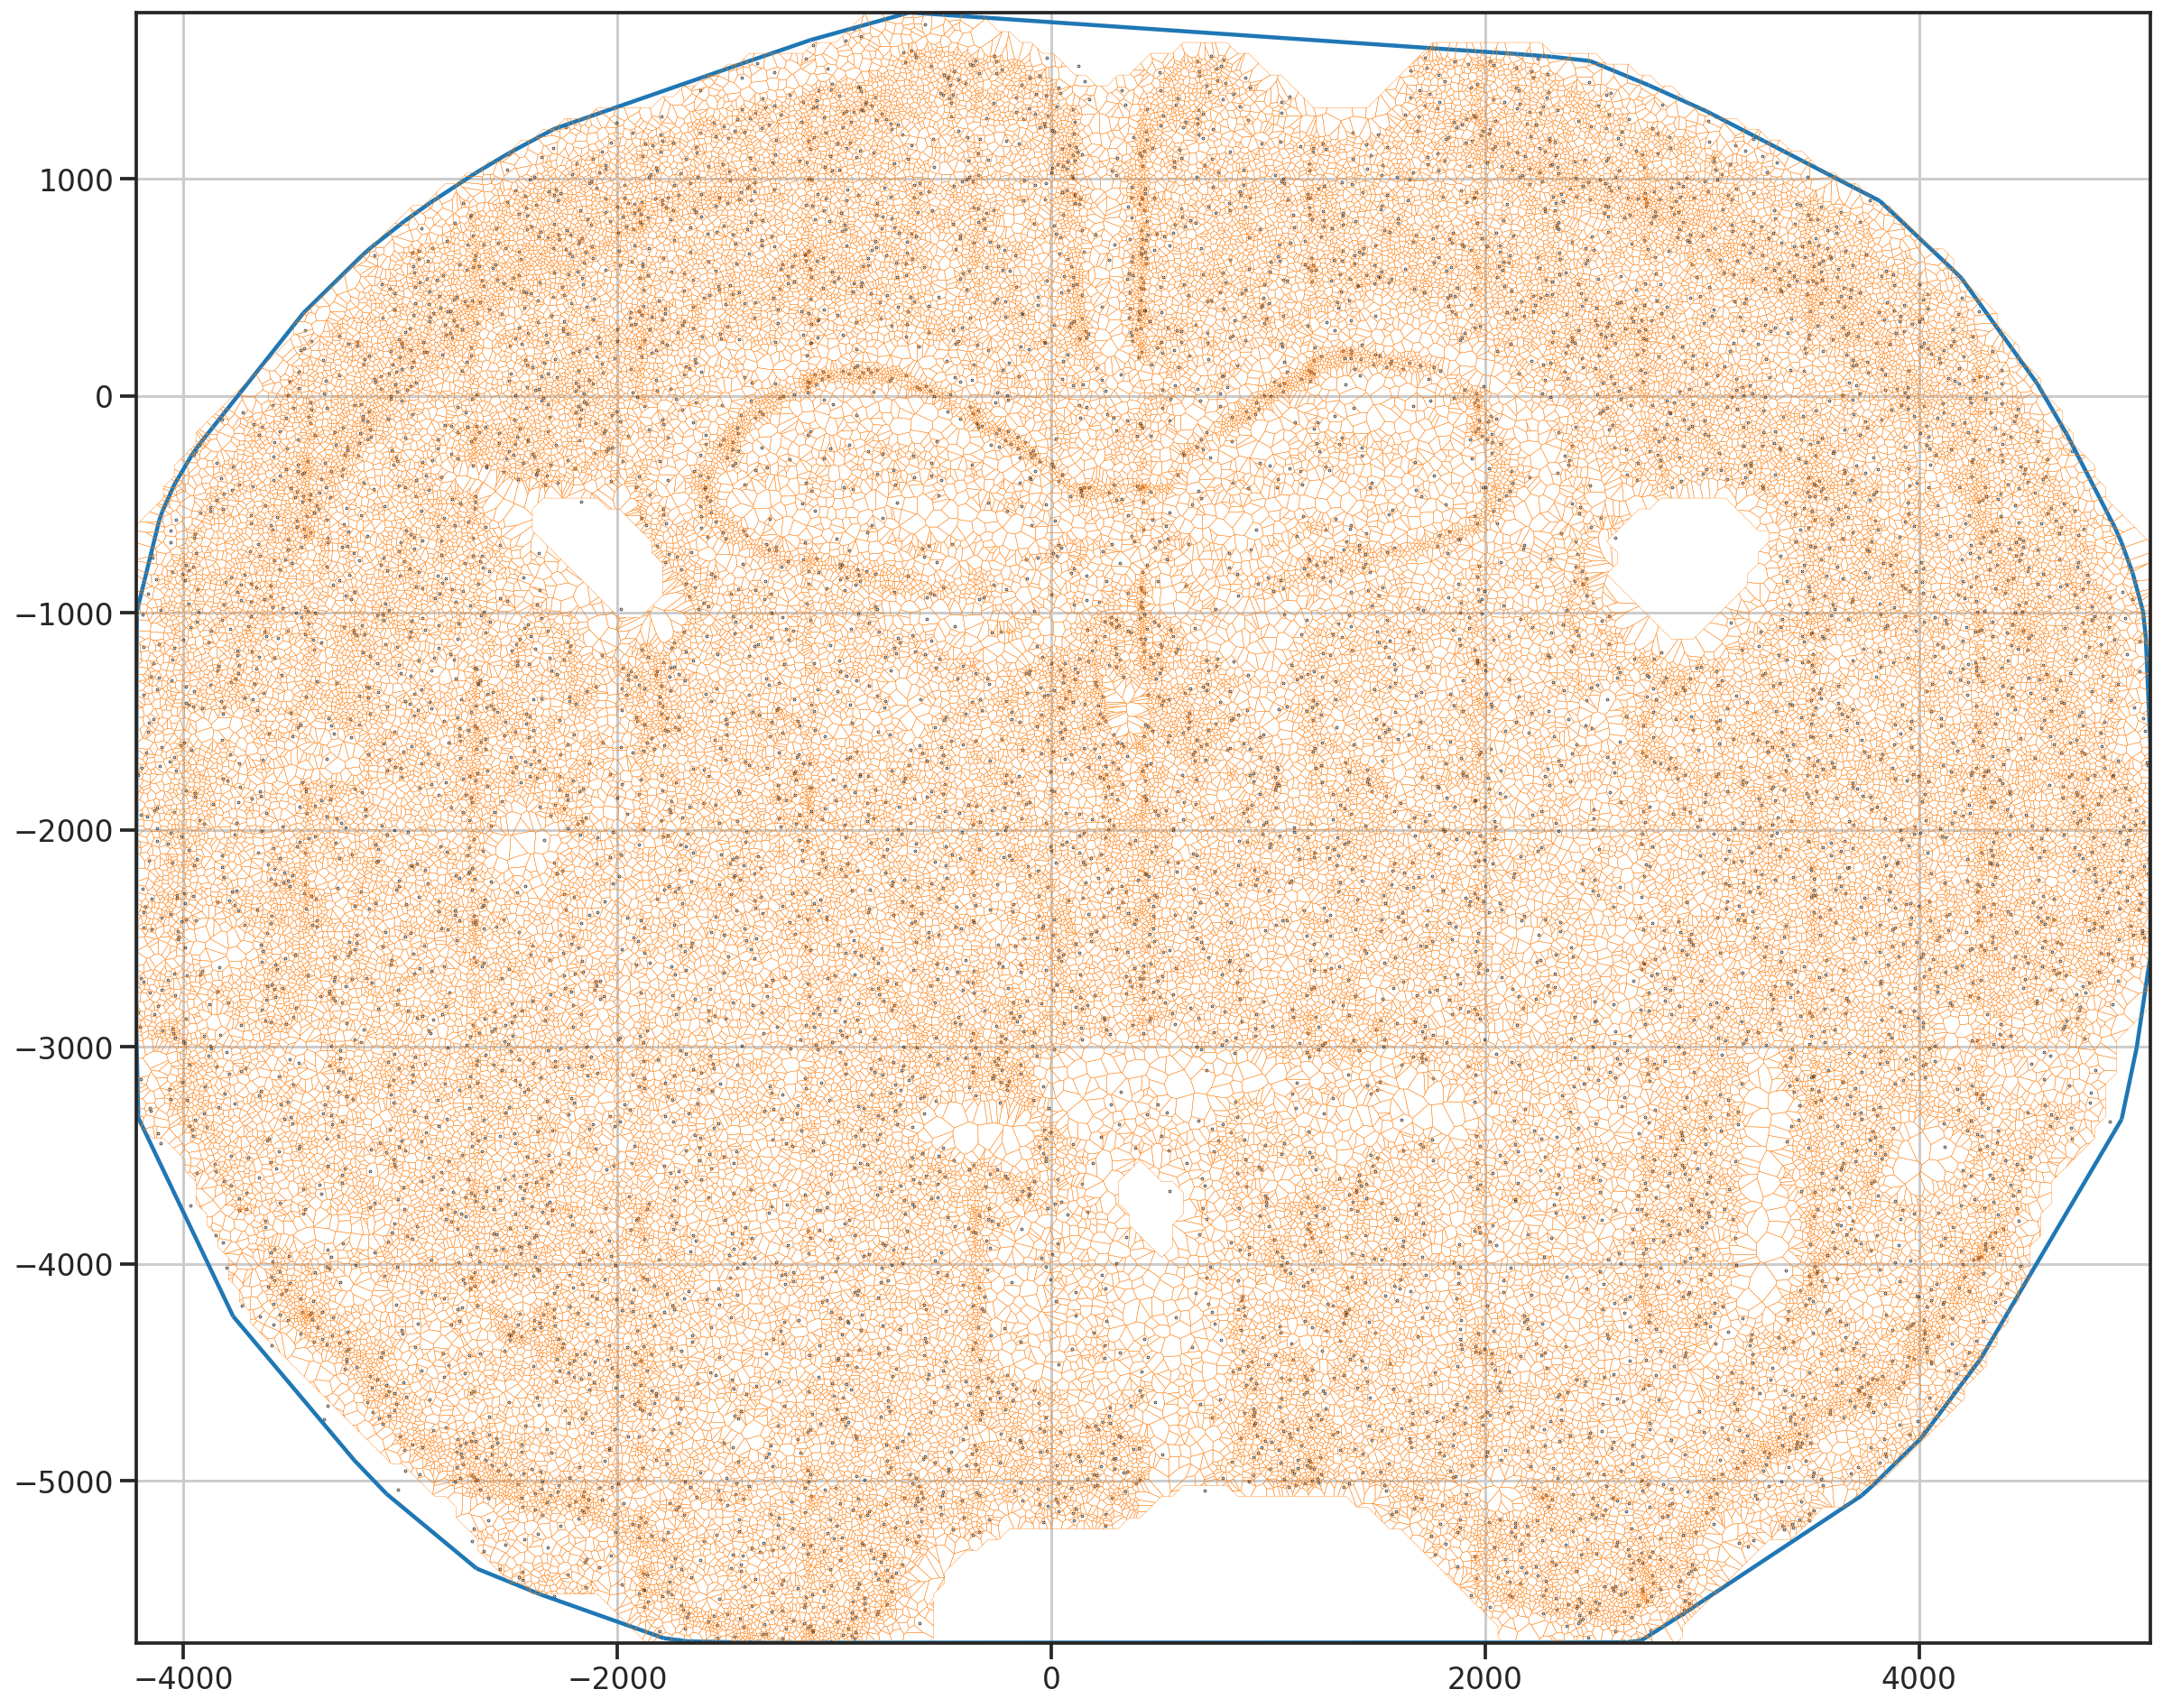

In [11]:
polys = XY[dd.convex_hull]
polys2 = TMG.Geoms[0]['poly'] #) #) #[0]

xcoords = polys[:,:,0]
xmin, xmax = np.min(xcoords), np.max(xcoords)

ycoords = polys[:,:,1]
ymin, ymax = np.min(ycoords), np.max(ycoords)

fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(XY[::10,0], XY[::10,1], s=0.1, color='k')
p2 = LineCollection(polys2, color='C1', linewidth=0.2)
p = LineCollection(polys)
ax.add_collection(p)
ax.add_collection(p2)
ax.set_aspect('equal') #, 'box')
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.show()

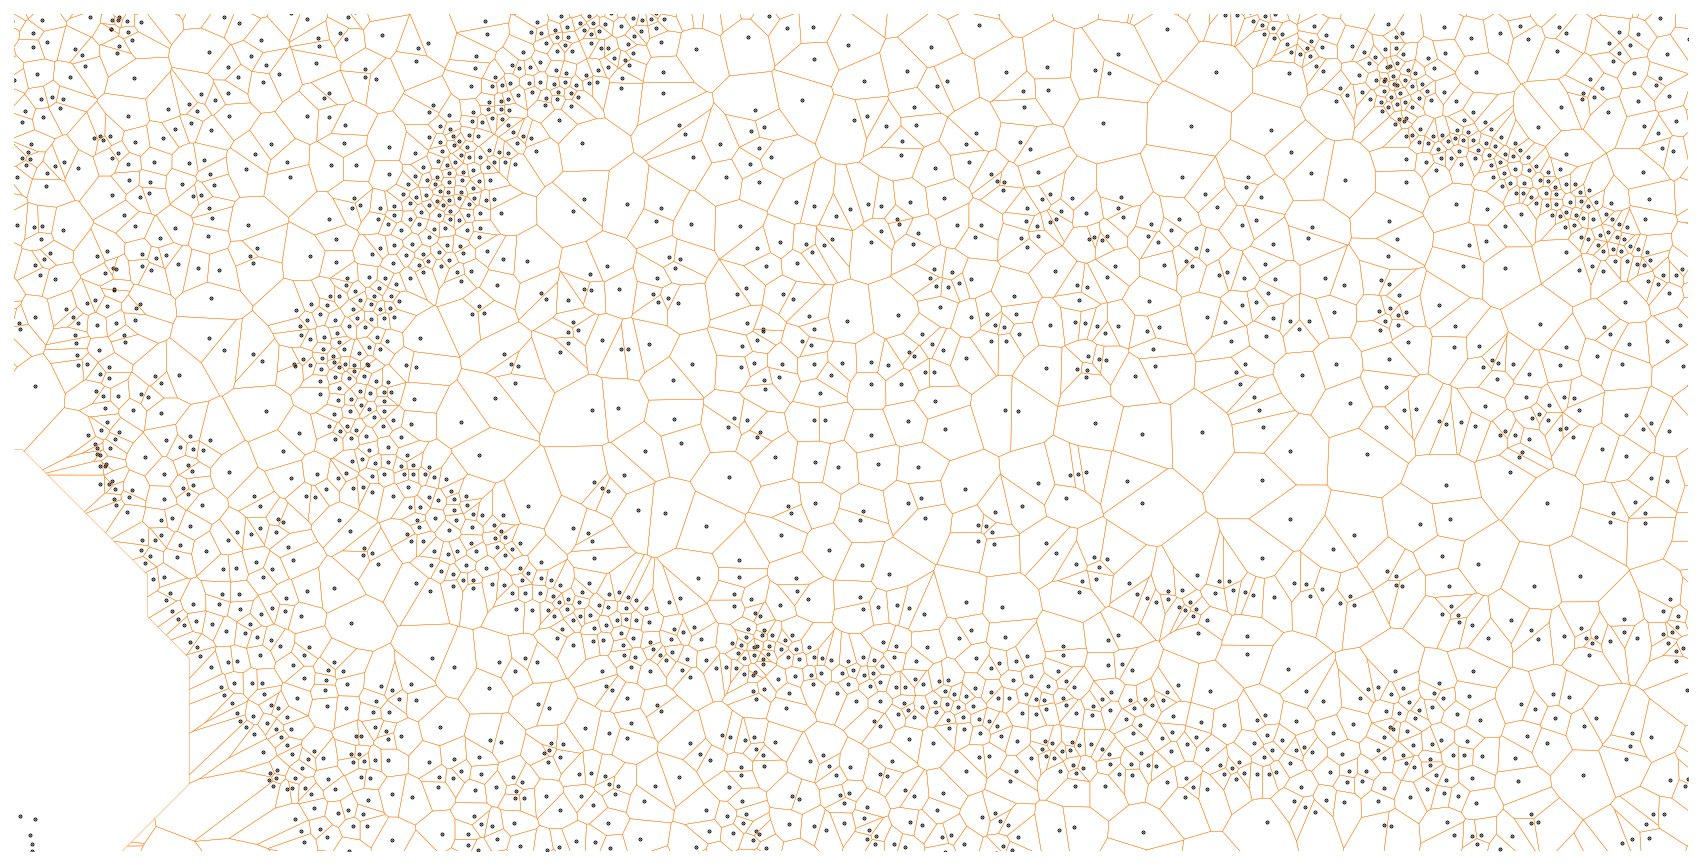

In [12]:
polys = XY[dd.convex_hull]
polys2 = TMG.Geoms[0]['poly'] #) #) #[0]

xcoords = polys[:,:,0]
xmin, xmax = np.min(xcoords), np.max(xcoords)

ycoords = polys[:,:,1]
ymin, ymax = np.min(ycoords), np.max(ycoords)

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(XY[::,0], XY[::,1], s=0.2, color='k')
p2 = LineCollection(polys2, color='C1', linewidth=0.2)
p = LineCollection(polys)
ax.add_collection(p)
ax.add_collection(p2)
ax.set_aspect('equal') #, 'box')
ax.set_xlim(-2000,0) #xmin, xmax)
ax.set_ylim(-1000,0) #ymin, ymax)
ax.axis('off')

plt.show()